## Install dependencies

In [1]:
#!pip install git+https://github.com/jthermiz/nma_timely_tigers --quiet
from nma_timely_tigers import utils, models
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd

In [2]:
from importlib import reload
reload(utils)

<module 'nma_timely_tigers.utils' from '/home/jhermiz/projects/nma_timely_tigers/nma_timely_tigers/utils.py'>

In [3]:
%matplotlib inline

## Load dataset

In [4]:
alldat = utils.load_steinmetz_dataset() # note this takes a bit bc it downloads data

Loading data from disk


## Fixed parameters

In [9]:
p = {}
#p['areas'] = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
p['areas'] = ["VISp"]
p['start_time'] = 0.5
p['end_time'] = 1.2
p['optimizer'] = torch.optim.Adam
p['epochs'] = 2000
p['early_stop_count'] = 200
p['exp_name'] = 'all_session_visp'

## Sweeping parameter(s)

In [10]:
s = {}
s['hidden_units'] = [100]

## Main loop

0
using GPU
On epoch 0 of 2000
Train accuracy: 34.228
Validation accuracy: 33.846

Early stopped at 430
Finished training!


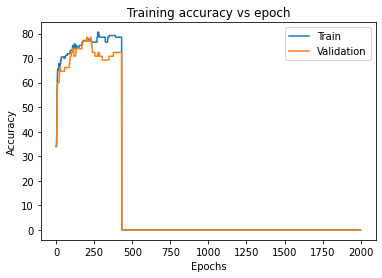

using GPU
On epoch 0 of 2000
Train accuracy: 34.228
Validation accuracy: 33.846

On epoch 1000 of 2000
Train accuracy: 100.0
Validation accuracy: 93.846

Early stopped at 1115
Finished training!


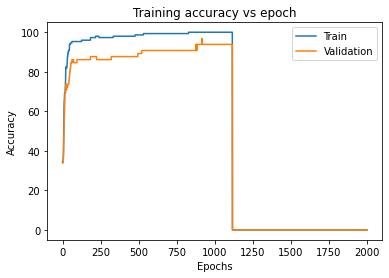

using GPU
On epoch 0 of 2000
Train accuracy: 40.94
Validation accuracy: 43.077

Early stopped at 250
Finished training!


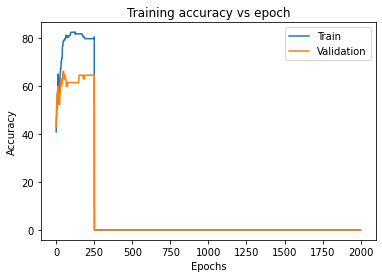

using GPU
On epoch 0 of 2000
Train accuracy: 44.295
Validation accuracy: 33.846

On epoch 1000 of 2000
Train accuracy: 100.0
Validation accuracy: 75.385

Early stopped at 1172
Finished training!


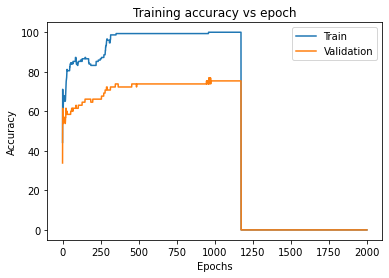

1
2
using GPU
On epoch 0 of 2000
Train accuracy: 24.528
Validation accuracy: 33.333

Early stopped at 205
Finished training!


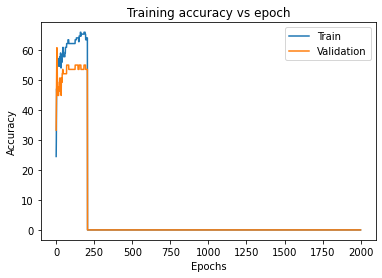

using GPU
On epoch 0 of 2000
Train accuracy: 38.994
Validation accuracy: 37.681

Early stopped at 222
Finished training!


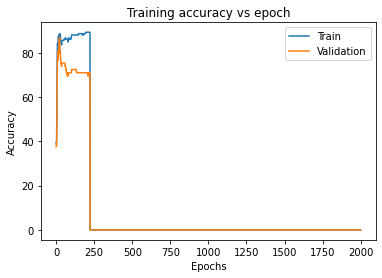

using GPU
On epoch 0 of 2000
Train accuracy: 64.78
Validation accuracy: 62.319

Early stopped at 406
Finished training!


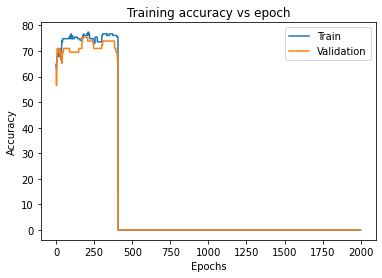

using GPU
On epoch 0 of 2000
Train accuracy: 29.56
Validation accuracy: 26.087

Early stopped at 221
Finished training!


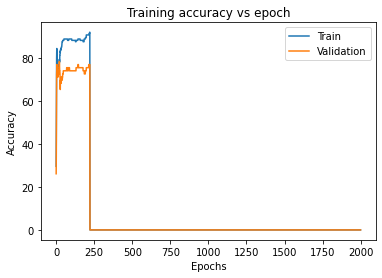

3
using GPU
On epoch 0 of 2000
Train accuracy: 50.0
Validation accuracy: 44.0

Early stopped at 202
Finished training!


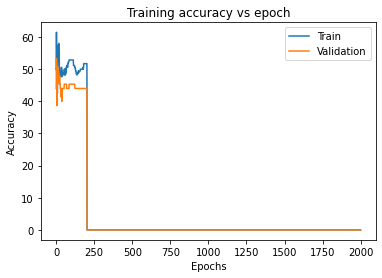

using GPU
On epoch 0 of 2000
Train accuracy: 19.54
Validation accuracy: 20.0

Early stopped at 270
Finished training!


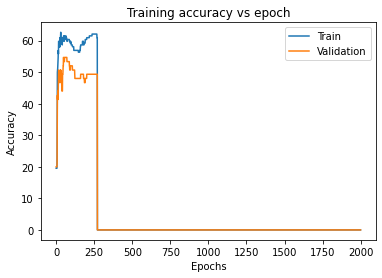

using GPU
On epoch 0 of 2000
Train accuracy: 32.184
Validation accuracy: 29.333

Early stopped at 376
Finished training!


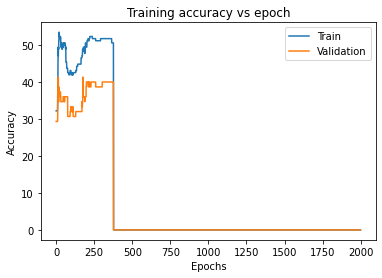

using GPU
On epoch 0 of 2000
Train accuracy: 29.885
Validation accuracy: 32.0

Early stopped at 308
Finished training!


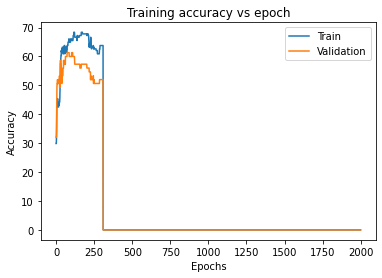

4
5
6
7
using GPU
On epoch 0 of 2000
Train accuracy: 41.143
Validation accuracy: 30.667

Early stopped at 242
Finished training!


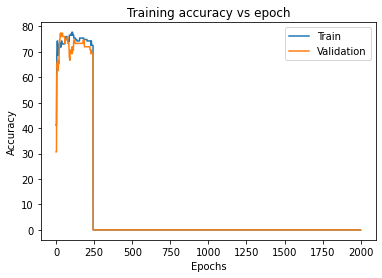

using GPU
On epoch 0 of 2000
Train accuracy: 42.286
Validation accuracy: 30.667

Early stopped at 896
Finished training!


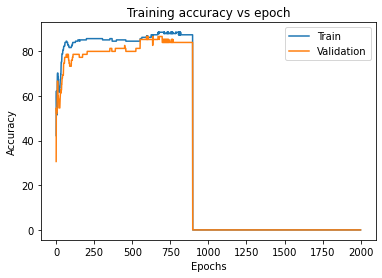

using GPU
On epoch 0 of 2000
Train accuracy: 40.571
Validation accuracy: 32.0

Early stopped at 529
Finished training!


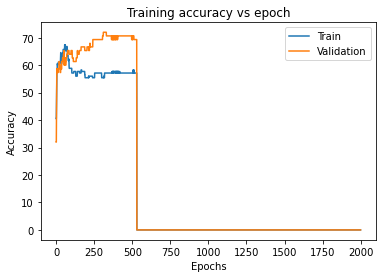

using GPU
On epoch 0 of 2000
Train accuracy: 40.571
Validation accuracy: 32.0

Early stopped at 231
Finished training!


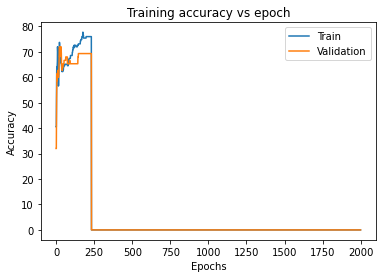

8
9
using GPU
On epoch 0 of 2000
Train accuracy: 26.282
Validation accuracy: 22.222

Early stopped at 439
Finished training!


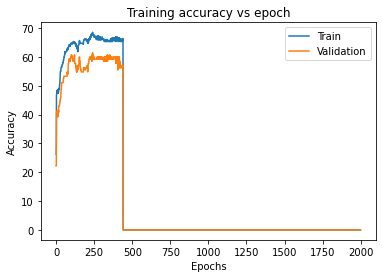

using GPU
On epoch 0 of 2000
Train accuracy: 33.013
Validation accuracy: 34.074

Early stopped at 414
Finished training!


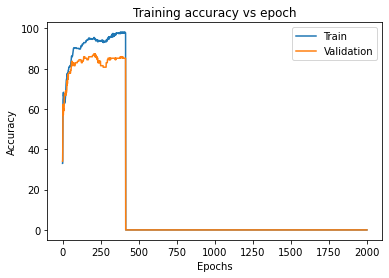

using GPU
On epoch 0 of 2000
Train accuracy: 32.692
Validation accuracy: 28.889

Early stopped at 506
Finished training!


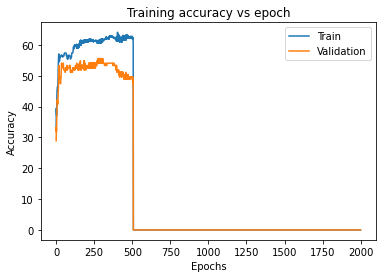

using GPU
On epoch 0 of 2000
Train accuracy: 39.103
Validation accuracy: 47.407

Early stopped at 227
Finished training!


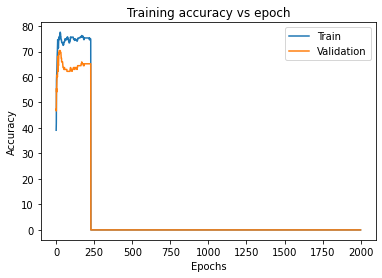

10
11
using GPU
On epoch 0 of 2000
Train accuracy: 19.409
Validation accuracy: 19.417

Early stopped at 229
Finished training!


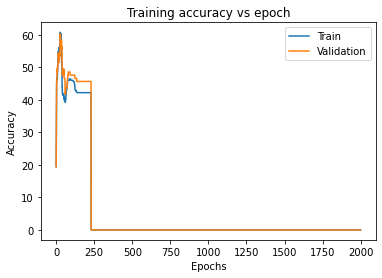

using GPU
On epoch 0 of 2000
Train accuracy: 19.409
Validation accuracy: 19.417

Early stopped at 568
Finished training!


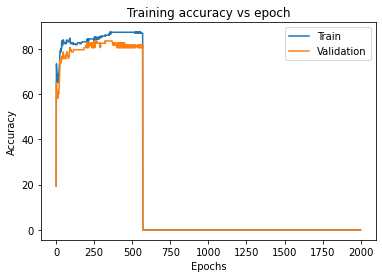

using GPU
On epoch 0 of 2000
Train accuracy: 65.401
Validation accuracy: 62.136

Early stopped at 826
Finished training!


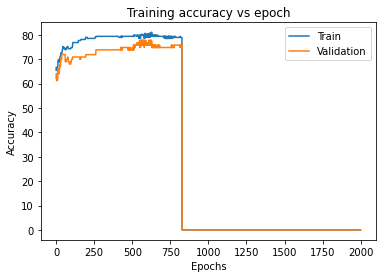

using GPU
On epoch 0 of 2000
Train accuracy: 27.004
Validation accuracy: 29.126

Early stopped at 546
Finished training!


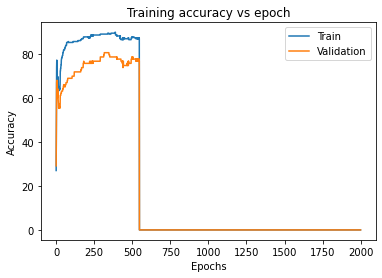

12
13
using GPU
On epoch 0 of 2000
Train accuracy: 19.251
Validation accuracy: 17.284

Early stopped at 220
Finished training!


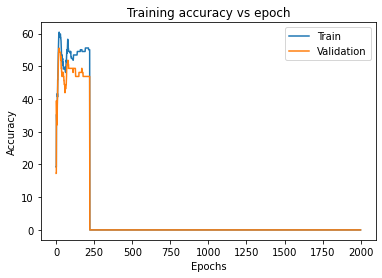

using GPU
On epoch 0 of 2000
Train accuracy: 32.62
Validation accuracy: 32.099

Early stopped at 294
Finished training!


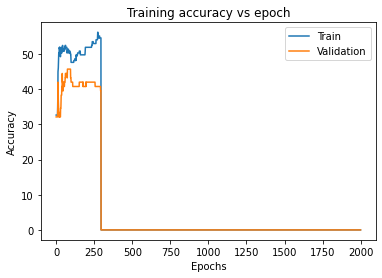

using GPU
On epoch 0 of 2000
Train accuracy: 33.69
Validation accuracy: 32.099

Early stopped at 217
Finished training!


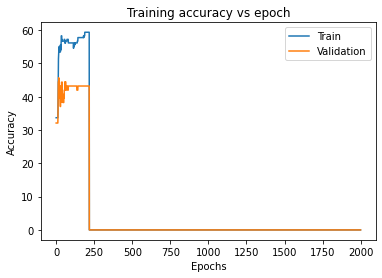

using GPU
On epoch 0 of 2000
Train accuracy: 36.898
Validation accuracy: 27.16

Early stopped at 214
Finished training!


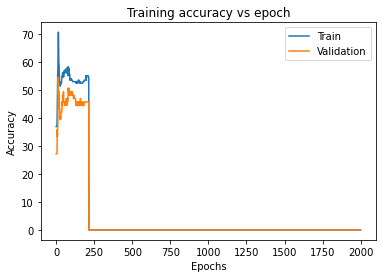

14
15
16
17
18
19
using GPU
On epoch 0 of 2000
Train accuracy: 42.683
Validation accuracy: 42.254

Early stopped at 297
Finished training!


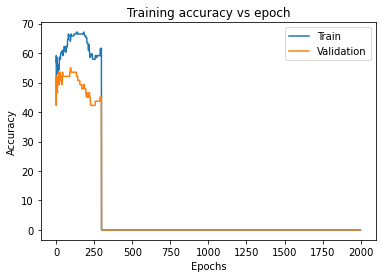

using GPU
On epoch 0 of 2000
Train accuracy: 39.024
Validation accuracy: 38.028

Early stopped at 204
Finished training!


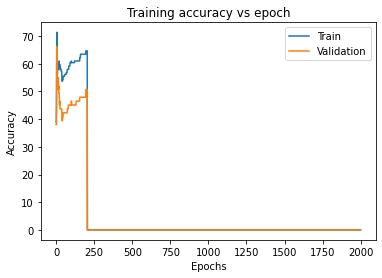

using GPU
On epoch 0 of 2000
Train accuracy: 42.073
Validation accuracy: 42.254

Early stopped at 221
Finished training!


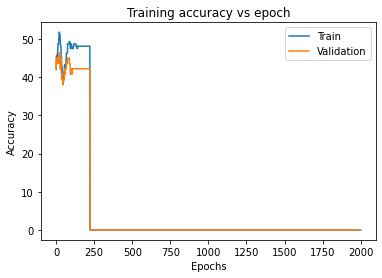

using GPU
On epoch 0 of 2000
Train accuracy: 32.317
Validation accuracy: 30.986

Early stopped at 976
Finished training!


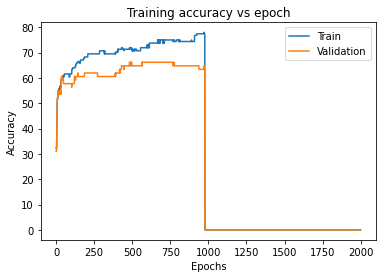

20
21
using GPU
On epoch 0 of 2000
Train accuracy: 36.452
Validation accuracy: 33.582

Early stopped at 529
Finished training!


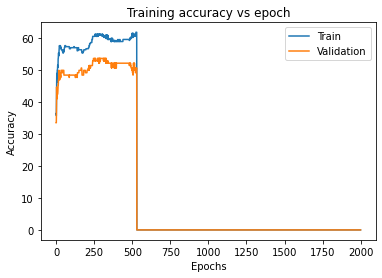

using GPU
On epoch 0 of 2000
Train accuracy: 44.839
Validation accuracy: 46.269

Early stopped at 205
Finished training!


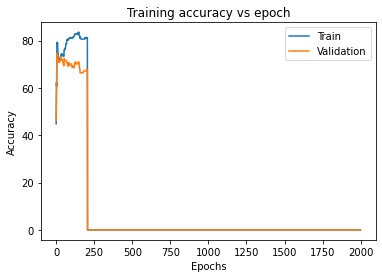

using GPU
On epoch 0 of 2000
Train accuracy: 44.839
Validation accuracy: 43.284

Early stopped at 200
Finished training!


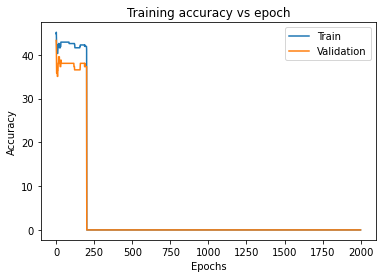

using GPU
On epoch 0 of 2000
Train accuracy: 44.194
Validation accuracy: 47.015

Early stopped at 742
Finished training!


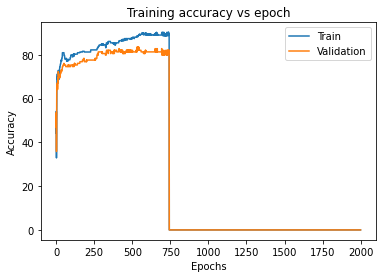

22
23
24
using GPU
On epoch 0 of 2000
Train accuracy: 29.121
Validation accuracy: 35.443

Early stopped at 205
Finished training!


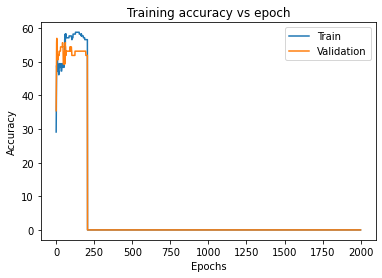

using GPU
On epoch 0 of 2000
Train accuracy: 31.319
Validation accuracy: 34.177

Early stopped at 276
Finished training!


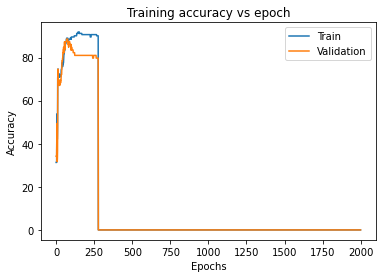

using GPU
On epoch 0 of 2000
Train accuracy: 37.912
Validation accuracy: 31.646

Early stopped at 501
Finished training!


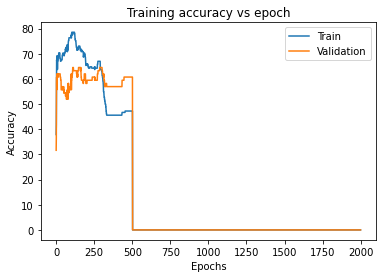

using GPU
On epoch 0 of 2000
Train accuracy: 39.011
Validation accuracy: 34.177

Early stopped at 735
Finished training!


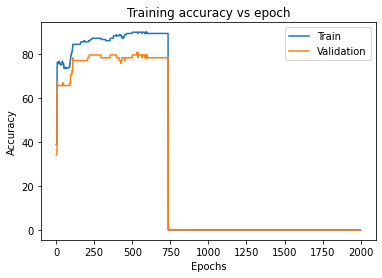

25
using GPU
On epoch 0 of 2000
Train accuracy: 29.032
Validation accuracy: 16.667

Early stopped at 269
Finished training!


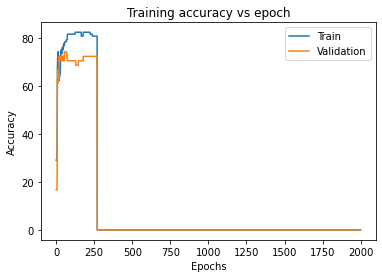

using GPU
On epoch 0 of 2000
Train accuracy: 42.742
Validation accuracy: 62.963

Early stopped at 477
Finished training!


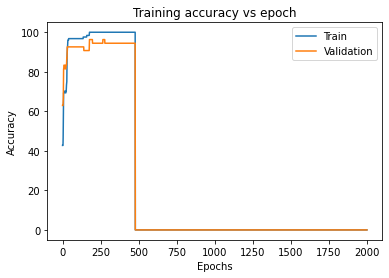

using GPU
On epoch 0 of 2000
Train accuracy: 24.194
Validation accuracy: 31.481

Early stopped at 213
Finished training!


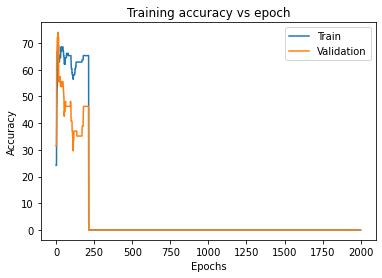

using GPU
On epoch 0 of 2000
Train accuracy: 37.903
Validation accuracy: 51.852

On epoch 1000 of 2000
Train accuracy: 91.129
Validation accuracy: 81.481

Early stopped at 1299
Finished training!


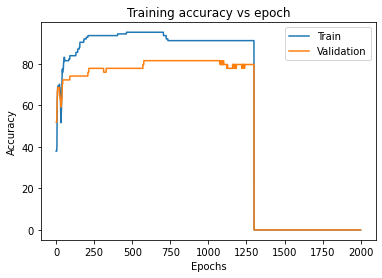

26
27
28
29
30
31
32
33
34
35
36
37
38
using GPU
On epoch 0 of 2000
Train accuracy: 29.583
Validation accuracy: 34.951

Early stopped at 451
Finished training!


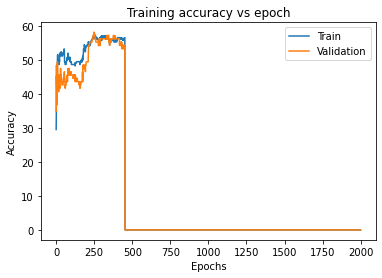

using GPU
On epoch 0 of 2000
Train accuracy: 29.167
Validation accuracy: 28.155

Early stopped at 206
Finished training!


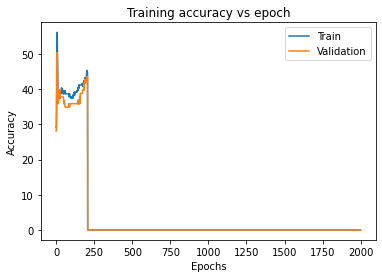

using GPU
On epoch 0 of 2000
Train accuracy: 29.167
Validation accuracy: 38.835

Early stopped at 277
Finished training!


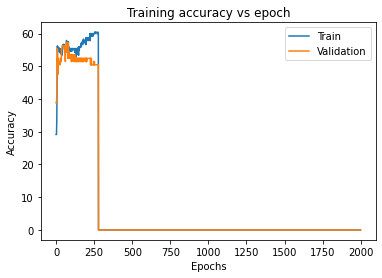

using GPU
On epoch 0 of 2000
Train accuracy: 42.5
Validation accuracy: 39.806

Early stopped at 404
Finished training!


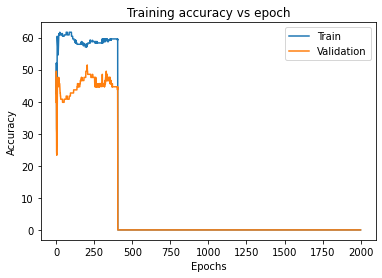

In [11]:
results = []
for session, dat in enumerate(alldat[:]):
    print(session)
    for param in s['hidden_units']:      
        for stim in [False, True]:
            for shuf in [False, True]:
                spks, _ = utils.get_neurons_by_brain_area(dat, areas=p['areas'])                 
                
                y = dat['response'] + 1 
                if stim:
                    y = utils.stimulus_labels(dat)
                
                X = utils.average_trials_across_time(spks, 
                                                    start_time=p['start_time'],
                                                    end_time=p['end_time'],
                                                    fs=100).T                
                
                if shuf:
                    X = utils.shuffle_neurons(X, y)

                # must have >10 neurons
                if X.shape[1] > 10:
                    net = models.TwoLayer(D_in=X.shape[1], H=param, D_out=3)
                    acc_df, last_epoch = utils.train(net, X, y, 
                                         epochs=p['epochs'],
                                         optimizer=torch.optim.Adam(net.parameters()),
                                         early_stop_count=p['early_stop_count'])  
                    result = {'session': session, list(s.keys())[0]: param, 
                              'shuffle': shuf, 'stimulus_decode': stim,
                              'accuracy_epoch': acc_df, 
                              'test_accuracy':acc_df.values[last_epoch,1]}
                    results.append(result)
                    fig, ax = utils.plot_accuracy(acc_df)
                    #plt.savefig('test.png', dpi=300)

## Save data to disk

In [12]:
results_df = pd.DataFrame(results)
results_df.head()

,session,hidden_units,shuffle,stimulus_decode,accuracy_epoch,test_accuracy
0,0,100,False,False,Train Validation 0 34.228188 ...,72.307692
1,0,100,True,False,Train Validation 0 34.228188 ...,93.846154
2,0,100,False,True,Train Validation 0 40.939597 ...,64.615385
3,0,100,True,True,Train Validation 0 44.295302 ...,75.384615
4,2,100,False,False,Train Validation 0 24.528302 ...,53.623188


In [13]:
results_df.to_pickle(p['exp_name'] + '_results' + '.pkl')
pd.DataFrame(p).loc[0].to_pickle(p['exp_name'] + '_parameters' + '.pkl')
!ls

 all_session_fixed_shuf_parameters.pkl	 neuron_correlations_results.pkl
 all_session_fixed_shuf_results.pkl	 steinmetz_part0.npz
 all_session_parameters.pkl		 steinmetz_part1.npz
 all_session_results.pkl		 steinmetz_part2.npz
 all_session_visp_parameters.pkl	'Sweep model.ipynb'
 all_session_visp_results.pkl		 Template_pipeline.ipynb
'Neuron correlations.ipynb'		 Untitled.ipynb
 neuron_correlations_parameters.pkl


## Post hoc analysis

In [14]:
# for idx, row in results_df.iterrows():
#     mask = row['accuracy_epoch']['Train'] > 0
#     tmp = row['accuracy_epoch'][mask]
#     results_df['test_accuracy'][idx] = tmp.values[-1, 1]

# results_df['test_accuracy'].head()

In [15]:
results_df.head()

,session,hidden_units,shuffle,stimulus_decode,accuracy_epoch,test_accuracy
0,0,100,False,False,Train Validation 0 34.228188 ...,72.307692
1,0,100,True,False,Train Validation 0 34.228188 ...,93.846154
2,0,100,False,True,Train Validation 0 40.939597 ...,64.615385
3,0,100,True,True,Train Validation 0 44.295302 ...,75.384615
4,2,100,False,False,Train Validation 0 24.528302 ...,53.623188


/home/jhermiz/anaconda3/envs/nma/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jhermiz/anaconda3/envs/nma/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


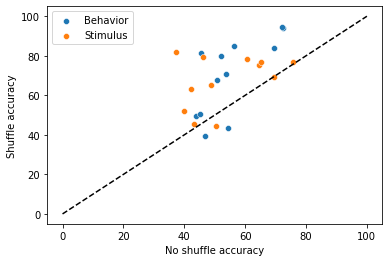

In [16]:
for stim in [False, True]:
    tmp = results_df[results_df['stimulus_decode'] == stim]
    no_shuf = tmp['test_accuracy'][::2]
    shuf = tmp['test_accuracy'][1::2]
    sns.scatterplot(no_shuf.values, shuf.values)    
    plt.xlabel('No shuffle accuracy')
    plt.ylabel('Shuffle accuracy')
plt.legend(['Behavior', 'Stimulus'])
plt.plot([0, 100], [0, 100], 'k--')

In [17]:
tmp = results_df[results_df['stimulus_decode'] == False]
stats = tmp.groupby('shuffle').agg(['describe'])['test_accuracy']
stats

describe                                                         \
           count       mean        std        min        25%        50%   
shuffle                                                                   
False       12.0  55.200978  10.468875  44.000000  46.592952  52.760961   
True        12.0  70.077834  19.651805  39.506173  50.361502  75.380664   

                               
               75%        max  
shuffle                        
False    59.555556  72.307692  
True     84.296296  94.444444

In [18]:
tmp = results_df[results_df['stimulus_decode'] == True]
stats = tmp.groupby('shuffle').agg(['describe'])['test_accuracy']
stats

describe                                                         \
           count       mean        std        min        25%        50%   
shuffle                                                                   
False       12.0  53.675101  12.851724  37.313433  42.970788  49.687163   
True        12.0  67.444453  13.408876  44.660194  60.535211  72.358974   

                               
               75%        max  
shuffle                        
False    64.765886  75.728155  
True     77.228949  82.089552